In [286]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import copy
import time
import math
import statistics
from scipy.spatial.distance import cdist
# from dtaidistance import dtw

Populating the interactive namespace from numpy and matplotlib


D:\Program Files\Programs\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist', 'test', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load Files

In [287]:
# file_test = '50words_TEST'
# file_train = '50words_TRAIN'

file_test = 'Lightning7_TEST'
file_train = 'Lightning7_TRAIN'

# Read files
with open(file_test) as f:
    ts_test = f.read().splitlines()
with open(file_train) as f:
    ts_train = f.read().splitlines()


# Train Data
ts_train = [x.split() for x in ts_train]
ts_train = [[float(s) for s in row] for row in ts_train] 
ts_train = np.array(ts_train) # convert to numpy array
train_data = copy.deepcopy(ts_train)
train_classes = ts_train[:,0]  # get the classes
ts_train = np.delete(ts_train, np.s_[:1], axis=1) # remove the first column, which is the class



# Test Data
ts_test = [x.split() for x in ts_test]
ts_test = [[float(s) for s in row] for row in ts_test]
ts_test = np.array(ts_test) # convert to numpy array
test_classes = ts_test[:,0] # get the classes
test_data = copy.deepcopy(ts_test)
ts_test = np.delete(ts_test, np.s_[:1], axis=1) # remove the first column, which is the class

actual_classes = test_classes
# ts_test = pd.Series(ts_test)
# ts_train = pd.Series(ts_train)7

# Normalize (not used)

In [288]:
def z_normalize(ts):
    label = ts[0]
    z_mean = statistics.mean(ts[1:])
    z_sd = statistics.pstdev(ts[1:])
    res = np.array([(x-z_mean)/z_sd for x in ts])
    res = np.insert(res, 0, label)
    return res
# mean = statistics.mean(test_data)
normalized_test = np.array([z_normalize(x) for x in test_data])
normalized_train = np.array([z_normalize(x) for x in train_data])


# DTW
# Must get the data with header (Class/Label) as parameters

In [400]:
def DTW(s1,s2,window_size,weight=(1,1,1)):
##     s1 = np.insert(ts1,0,0)
##     s2 = np.insert(ts2,0,0)

    # Initilize variables
    n,m = len(s1) ,len(s2)
    window_size = int(window_size)
    w1,w2,w3 = weight[0],weight[1],weight[2]
    matrix= np.ones((n,m)) * np.inf
    matrix[0][0] = 0
    
    # Calculate the DTW
    for i in range(1,n):
        for j in range(max(1, i-window_size),min(m, i+window_size)):
            cost = (s1[i]-s2[j])**2
            matrix[i][j] = min(matrix[i-1][j] + w1*cost,
                               matrix[i-1][j-1] + w2*cost,
                               matrix[i][j-1] + w3*cost)
        
    
    ## Calculate the Warping Path
    i, j = np.array(matrix.shape) - 2
    p, q = [i], [j]
    while(i>0 or j >0):
        tb = np.argmin((matrix[i, j], matrix[i, j+1], matrix[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    path = np.array(p), np.array(q)  
    # Calculate the assoc!!
    assoc = [set() for i in range(n)]
    for i in range(len(path[0])):
        pos = int(path[0][i])
#         print (pos)
        assoc[pos].add(int(path[1][i]))
    distance = matrix[n-1][m-1]
    distance = math.sqrt(distance)
    return distance,matrix,path,assoc

In [401]:
test = test_data[:10]
dist, matrix, path,assoc = DTW(test[9], train_data[19], len(test_data[0]))

In [382]:
# def dtw(x, y, dist):
#     """
#     Computes Dynamic Time Warping (DTW) of two sequences.
#     :param array x: N1*M array
#     :param array y: N2*M array
#     :param func dist: distance used as cost measure
#     Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
#     """
#     assert len(x)
#     assert len(y)
#     r, c = len(x), len(y)
#     D0 = zeros((r + 1, c + 1))
#     D0[0, 1:] = inf
#     D0[1:, 0] = inf
#     D1 = D0[1:, 1:] # view
#     for i in range(r):
#         for j in range(c):
#             D1[i, j] = dist(x[i], y[j])
#     C = D1.copy()
#     for i in range(r):
#         for j in range(c):
#             D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
#     if len(x)==1:
#         path = zeros(len(y)), range(len(y))
#     elif len(y) == 1:
#         path = range(len(x)), zeros(len(x))
#     else:
#         path = _traceback(D0)
# #     return D1[-1, -1] / sum(D1.shape), C, D1, path
#     return D1[-1, -1], C, D1, path    
# def _traceback(D):
#     i, j = array(D.shape) - 2
#     p, q = [i], [j]
#     while ((i > 0) or (j > 0)):
#         tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
#         if (tb == 0):
#             i -= 1
#             j -= 1
#         elif (tb == 1):
#             i -= 1
#         else: # (tb == 2):
#             j -= 1
#         p.insert(0, i)
#         q.insert(0, j)
#     return array(p), array(q)

# test = ts_test[:10]
# dist, cost, acc, path = dtw(test[9].reshape(-1,1), ts_train[19].reshape(-1,1), dist=lambda x, y: norm(x - y, ord=2))

(-0.5, 318.5)

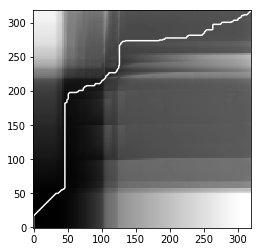

In [373]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))

# Plotting the original

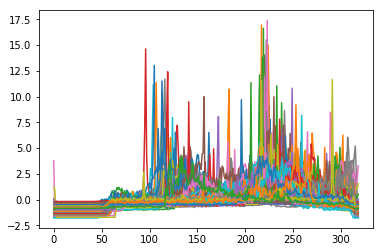

In [404]:
all_data_without_header = np.concatenate((ts_test.copy(), ts_train.copy()), axis=0) 
all_data_with_header = np.concatenate((test_data.copy(), train_data.copy()), axis=0) 
for x in all_data_without_header:
    plt.plot(x)
plt.show() 

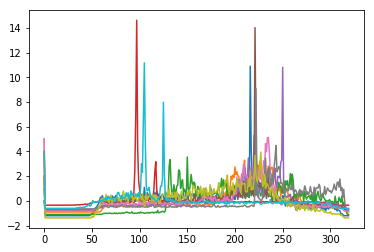

In [405]:
test = all_data_with_header[:10]
for x in test:
    plt.plot(x)
plt.show() 

# source:
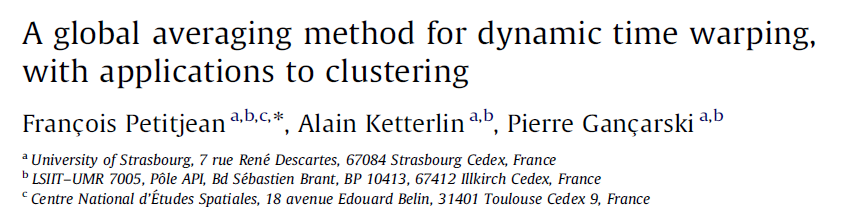

# DBA
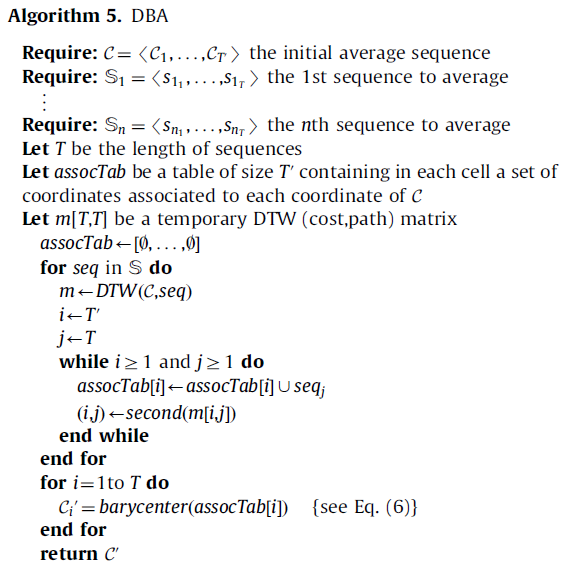

In [415]:
def barycenter(X):
    l = len(X)
    X = list(X)
#     for i in range(l):
#         res += X[i]
    return sum(X)/len(X)
def DBA(S):
    res = np.zeros(S[0].shape)
    T = len(S[0])
    C = np.mean(S, axis=0)
    np.random.shuffle(S)    
    assocTable = [set() for i in range(T)]
    for seq in S:
        distance,matrix,path,assoc = DTW(C,seq,T)
        
        ### The 'Assoc' is a list of set that tells us what coordinate(s) 
        ### of seq "associates" with C when we did the DTW
        for i in range(T):
            for index in assoc[i]:
                assocTable[i].add(seq[index])
#             assocTable[i].add(seq[assoc[i]])

    for i in range(T):
        res[i] = barycenter(assocTable[i])
    return res

In [418]:
all_data_with_header = np.concatenate((test_data.copy(), train_data.copy()), axis=0) 
a = DBA(all_data_with_header)

c:\users\worse2worst\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


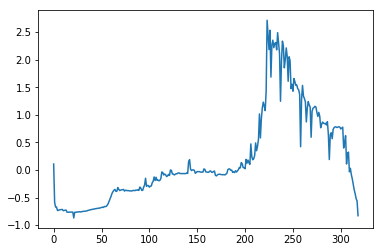

In [419]:
plt.plot(a)
plt.show()

In [ ]:
all_data_with_header = np.concatenate((test_data.copy(), train_data.copy()), axis=0) 
np.random.shuffle(all_data_with_header)
a = DBA(all_data_with_header)
plt.plot(a)
plt.show()

In [414]:
# """
# The :mod:`tslearn.barycenters` module gathers algorithms for time series barycenter computation.
# """

# # Code for soft DTW is by Mathieu Blondel under Simplified BSD license

# import numpy
# from scipy.interpolate import interp1d
# from scipy.optimize import minimize

# from tslearn.utils import to_time_series_dataset, check_equal_size
# from tslearn.preprocessing import TimeSeriesResampler
# from tslearn.metrics import dtw_path, SquaredEuclidean, SoftDTW


# __author__ = 'Romain Tavenard romain.tavenard[at]univ-rennes2.fr'


# def _set_weights(w, X):
#     if w is None or len(w) != len(X):
#         w = numpy.ones((X.shape[0],))
#     return w


# class EuclideanBarycenter:
#     """Standard Euclidean barycenter computed from a set of time series.
#     Parameters
#     ----------
#     weights: None or array
#         Weights of each X[i]. Must be the same size as len(X).
#     Note
#     ----
#         This method requires a dataset of equal-sized time series
#     Examples
#     --------
#     >>> time_series = [[1, 2, 3, 4], [1, 2, 4, 5]]
#     >>> bar = EuclideanBarycenter().fit(time_series)
#     >>> bar.shape
#     (4, 1)
#     >>> bar  # doctest: +ELLIPSIS
#     array([[ 1. ],
#            [ 2. ],
#            [ 3.5],
#            [ 4.5]])
#     """
#     def __init__(self, weights=None):
#         self.weights = weights

#     def fit(self, X):
#         """Compute the barycenter from a dataset of time series.
#         Parameters
#         ----------
#         X : array-like, shape=(n_ts, sz, d)
#             Time series dataset.
#         Returns
#         -------
#         numpy.array of shape (sz, d)
#             Barycenter of the provided time series dataset.
#         """
#         X_ = to_time_series_dataset(X)
#         self.weights = _set_weights(self.weights, X_)
#         return numpy.average(X_, axis=0, weights=self.weights)


# class DTWBarycenterAveraging(EuclideanBarycenter):
#     """DTW Barycenter Averaging (DBA) method.
#     DBA was originally presented in [1]_.
#     Parameters
#     ----------
#     weights: None or array
#         Weights of each X[i]. Must be the same size as len(X).
#     max_iter : int (default: 30)
#         Number of iterations of the EM procedure.
#     barycenter_size : int or None (default: None)
#         Size of the barycenter to generate. If None, the size of the barycenter is that of the data provided at fit
#         time or that of the initial barycenter if specified.
#     init_barycenter : array or None (default: None)
#         Initial barycenter to start from for the EM process.
#     tol : float (default: 1e-5)
#         Tolerance to use for early stopping: if the decrease in cost is lower than this value, the EM procedure stops.
#     verbose : boolean (default: False)
#         Whether to print information about the cost at each iteration or not.
#     Examples
#     --------
#     >>> time_series = [[1, 2, 3, 4], [1, 2, 4, 5]]
#     >>> euc_bar = EuclideanBarycenter().fit(time_series)
#     >>> dba_bar = DTWBarycenterAveraging(max_iter=0).fit(time_series)
#     >>> dba_bar.shape
#     (4, 1)
#     >>> numpy.alltrue(numpy.abs(euc_bar - dba_bar) < 1e-9)
#     True
#     >>> DTWBarycenterAveraging(max_iter=0, barycenter_size=5).fit(time_series).shape
#     (5, 1)
#     >>> DTWBarycenterAveraging(max_iter=5, barycenter_size=5, verbose=True).fit(time_series).shape  # doctest: +ELLIPSIS
#     [DBA] epoch 1, cost: ...
#     (5, 1)
    
#     References
#     ----------
#     .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method for dynamic time warping, with
#        applications to clustering. Pattern Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693
#     """
#     def __init__(self, weights=None, max_iter=30, barycenter_size=None, init_barycenter=None, tol=1e-5, verbose=False):
#         EuclideanBarycenter.__init__(self, weights=weights)
#         self.max_iter = max_iter
#         self.init_barycenter = init_barycenter
#         if init_barycenter is not None:
#             self.barycenter_size = init_barycenter.shape[0]
#         else:
#             self.barycenter_size = barycenter_size
#         self.tol = tol
#         self.verbose = verbose

#     def fit(self, X):
#         """Compute the barycenter from a dataset of time series.
#         Parameters
#         ----------
#         X : array-like, shape=(n_ts, sz, d)
#             Time series dataset.
#         Returns
#         -------
#         numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size is None
#             DBA barycenter of the provided time series dataset.
#         """
#         X_ = to_time_series_dataset(X)
#         if self.barycenter_size is None:
#             self.barycenter_size = X_.shape[1]
#         self.weights = _set_weights(self.weights, X_)
#         if self.init_barycenter is None:
#             barycenter = self._init_avg(X_)
#         else:
#             barycenter = self.init_barycenter
#         cost_prev, cost = numpy.inf, numpy.inf
#         for it in range(self.max_iter):
#             assign = self._petitjean_assignment(X_, barycenter)
#             cost = self._petitjean_cost(X_, barycenter, assign)
#             if self.verbose:
#                 print("[DBA] epoch %d, cost: %.3f" % (it + 1, cost))
#             barycenter = self._petitjean_update_barycenter(X_, assign)
#             if cost_prev < cost:
#                 raise ValueError
#             if cost_prev - cost < self.tol:
#                 break
#             else:
#                 cost_prev = cost
#         return barycenter

#     def _init_avg(self, X):
#         if X.shape[1] == self.barycenter_size:
#             return X.mean(axis=0)
#         else:
#             X_avg = X.mean(axis=0)
#             xnew = numpy.linspace(0, 1, self.barycenter_size)
#             f = interp1d(numpy.linspace(0, 1, X_avg.shape[0]), X_avg, kind="linear", axis=0)
#             return f(xnew)

#     def _petitjean_assignment(self, X, barycenter):
#         n = X.shape[0]
#         assign = ([[] for _ in range(self.barycenter_size)], [[] for _ in range(self.barycenter_size)])
#         for i in range(n):
#             path, _ = dtw_path(X[i], barycenter)
#             for pair in path:
#                 assign[0][pair[1]].append(i)
#                 assign[1][pair[1]].append(pair[0])
#         return assign

#     def _petitjean_update_barycenter(self, X, assign):
#         barycenter = numpy.zeros((self.barycenter_size, X.shape[-1]))
#         for t in range(self.barycenter_size):
#             barycenter[t] = numpy.average(X[assign[0][t], assign[1][t]], axis=0, weights=self.weights[assign[0][t]])
#         return barycenter

#     def _petitjean_cost(self, X, barycenter, assign):
#         cost = 0.
#         for t_barycenter in range(self.barycenter_size):
#             for i_ts, t_ts in zip(assign[0][t_barycenter], assign[1][t_barycenter]):
#                 cost += numpy.linalg.norm(X[i_ts, t_ts] - barycenter[t_barycenter]) ** 2
#         return cost / X.shape[0]


# class SoftDTWBarycenter(EuclideanBarycenter):
#     """Compute barycenter (time series averaging) under the soft-DTW geometry.
#     Parameters
#     ----------
#     gamma: float
#         Regularization parameter.
#         Lower is less smoothed (closer to true DTW).
#     weights: None or array
#         Weights of each X[i]. Must be the same size as len(X).
#     method: string
#         Optimization method, passed to `scipy.optimize.minimize`.
#         Default: L-BFGS.
#     tol: float
#         Tolerance of the method used.
#     max_iter: int
#         Maximum number of iterations.
#     Examples
#     --------
#     >>> time_series = [[1, 2, 3, 4], [1, 2, 4, 5]]
#     >>> euc_bar = EuclideanBarycenter().fit(time_series)
#     >>> stdw_bar = SoftDTWBarycenter(max_iter=0).fit(time_series)
#     >>> stdw_bar.shape
#     (4, 1)
#     >>> numpy.alltrue(numpy.abs(euc_bar - stdw_bar) < 1e-9)
#     True
#     >>> SoftDTWBarycenter(max_iter=5).fit(time_series).shape
#     (4, 1)
#     """
#     def __init__(self, gamma=1.0, weights=None, method="L-BFGS-B", tol=1e-3, max_iter=50, init=None):
#         EuclideanBarycenter.__init__(self, weights=weights)
#         self.method = method
#         self.tol = tol
#         self.gamma = gamma
#         self.max_iter = max_iter
#         self._X_fit = None
#         if init is None:
#             self.barycenter_ = None
#         else:
#             self.barycenter_ = init

#     def _func(self, Z):
#         # Compute objective value and grad at Z.

#         Z = Z.reshape(self.barycenter_.shape)

#         G = numpy.zeros_like(Z)

#         obj = 0

#         for i in range(len(self._X_fit)):
#             D = SquaredEuclidean(Z, self._X_fit[i])
#             sdtw = SoftDTW(D, gamma=self.gamma)
#             value = sdtw.compute()
#             E = sdtw.grad()
#             G_tmp = D.jacobian_product(E)
#             G += self.weights[i] * G_tmp
#             obj += self.weights[i] * value

#         return obj, G.ravel()

#     def fit(self, X):
#         self._X_fit = to_time_series_dataset(X)
#         self.weights = _set_weights(self.weights, self._X_fit)
#         if self.barycenter_ is None:
#             if check_equal_size(self._X_fit):
#                 self.barycenter_ = EuclideanBarycenter.fit(self, self._X_fit)
#             else:
#                 resampled_X = TimeSeriesResampler(sz=self._X_fit.shape[1]).fit_transform(self._X_fit)
#                 self.barycenter_ = EuclideanBarycenter.fit(self, resampled_X)

#         if self.max_iter > 0:
#             # The function works with vectors so we need to vectorize barycenter_.
#             res = minimize(self._func, self.barycenter_.ravel(), method=self.method, jac=True, tol=self.tol,
#                            options=dict(maxiter=self.max_iter, disp=False))
#             return res.x.reshape(self.barycenter_.shape)
#         else:
#             return self.barycenter_